In [258]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotting
import pickle
from nest import raster_plot
import numpy as np
import os
from scipy.signal import argrelextrema
import pylab
from importlib import reload # reload modules
reload(plotting)
# import warnings
# warnings.filterwarnings('ignore')

<module 'plotting' from '/home/adrossel/Magic/pickle/plotting.py'>

In [136]:
from jupyterthemes import jtplot
jtplot.style()
jtplot.style('default')

In [3]:
# Templating for latex code with Jinja2
from jinja2 import Template

In [4]:
# formatted latex string for figures
latex_header = r"""
    \documentclass[a4paper,12pt]{article}

    \usepackage[english]{babel}
    \usepackage{graphicx}
    \usepackage{subcaption}
    
    \usepackage{siunitx}

    \begin{document}
"""
latex_footer = r"\end{document}"
figure_template = Template(
    r"""
    \begin{figure}
    \centering
        \includegraphics[width={{ width }}\textwidth]{ {{figure}} }
        \caption{ {{ caption }} }
    \end{figure}
    """)
trace_latex_template = Template(
    r"""
\begin{figure}
    \centering
    \begin{subfigure}[b]{0.49\textwidth}
        \includegraphics[width=\textwidth]{ {{fig1}} }
        \caption{ {{caption1}} }
        \label{fig:gull}
    \end{subfigure}
    \begin{subfigure}[b]{0.49\textwidth}
        \includegraphics[width=\textwidth]{ {{fig2}} }
        \caption{ {{caption2}} }
        \label{fig:tiger}
    \end{subfigure}
    \caption{ {{caption_main}} }
    \label{fig:animals}
\end{figure}
    """)

In [5]:
def autocorr(df):
    bin_center, a = plotting.autoCorr(df)
    a = a/a.max()
    x = bin_center-0.3
    plt.plot(x, a)
    maxs = argrelextrema(a, np.greater)[0]
    plt.plot(x[maxs], a[maxs], 'ro')
    mid = int(maxs.size/2)
    period = x[maxs[mid+1]] - x[maxs[mid]]
    plt.plot([x[maxs[mid]], x[maxs[mid+1]]], [a[maxs[mid]], a[maxs[mid]]], 'g-', label="%.3f" % (period,) )
    periodicity = a[maxs[mid]] - a[maxs[mid+1]]
    plt.plot([x[maxs[mid+1]], x[maxs[mid+1]]], [a[maxs[mid+1]], a[maxs[mid]]], 'y-', label="%.3f" % (periodicity))
    plt.xlabel('Time (s)')
    plt.ylabel('ACF')
    plt.legend()

In [272]:
def dynamics_and_raster_plot(folder, save=True, latex=False):
    state_folder = ''
    params = pickle.load(open(folder+'/parameter.pickle', 'rb'))
    df_ex = pickle.load(open(folder+'/df_ex.pickle', 'rb'))
    df_in = pickle.load(open(folder+'/df_in.pickle', 'rb'))
    fig = plotting.visualisation_both(df_ex, df_in)
    if save: 
        fig_path_visu = folder+'_visu.pdf'
        fig.savefig(fig_path_visu, format='pdf')
#     fig_b, ax_b = plotting.visualization(df_in, title='Inhibitory Population')
#     plt.show()
#     if save: 
#         fig_path_visu_inh = folder+state_folder+'inh.eps'       
#         fig_b.savefig(fig_path_visu_inh, format='eps')
    df_ex_data = np.array(df_ex[['Sender', 'Time']].values.tolist())
    df_ex_data = np.array([[n_id, time] for n_id,time in df_ex_data if n_id < 1602 and
                          n_id > 2])
    raster = raster_plot.from_data(df_ex_data, title=r'Excitatory Population', rasterized=True)
#     plt.show()
    if save: 
        fig_path_raster_exc = folder+state_folder+'_exc_raster.eps'       
        plt.savefig(fig_path_raster_exc, format='eps')
    plt.show()
    autocorr(df_ex)
    if save:
        fig_path_autocorr_exc = folder+state_folder+'_exc_autocorr.eps'       
        plt.savefig(fig_path_autocorr_exc, format='eps')
    plt.show()
    periods = plotting.period(df_in)
    var = plotting.variance(df_in)
    df_in_data = np.array(df_in[['Sender', 'Time']].values.tolist())
    df_in_data = np.array([[n_id, time] for n_id,time in df_in_data if n_id > 25602 and
                        n_id < 27202])
    raster = raster_plot.from_data(df_in_data, title=r'Inhibitory Population', rasterized=True)
#     plt.show()
    if save: 
        fig_path_raster_inh = folder+state_folder+'_inh_raster.eps'       
        plt.savefig(fig_path_raster_inh, format='eps')
    plt.show()
    autocorr(df_in)
    if save:
        fig_path_autocorr_inh = folder+state_folder+'_inh_autocorr.eps'       
        plt.savefig(fig_path_autocorr_inh, format='eps')
    if latex:
        global visu_latex_string
        visu_latex_string += figure_template.render(figure=fig_path_visu,
                             caption=r"""
                             Time resolution for excitatory and inhibitorypopulation with 
                             $\nu_{exc,ext} = %.2f \,\si{Hz}$ and $\nu_{inh,ext} = %.2f \,\si{Hz}$.
                             """ % (params['Background rate excitatory'],
                                   params['Background rate inhibitory'], ),
                             width=1.0)
#         visu_latex_string += figure_template.render(figure=fig_path_visu_inh,
#                              caption=r"""
#                              Time resolution for inhibitory population with 
#                              $\nu_{exc,ext} = %.2f \,\si{Hz}$ and $\nu_{inh,ext} = %.2f \,\si{Hz}$.
#                              """ % (params['Background rate excitatory'],
#                                    params['Background rate inhibitory'], ),
#                              width=0.7)
        global raster_autocorr_latex_string
        raster_autocorr_latex_string += figure_template.render(figure=fig_path_raster_exc,
                             caption=r"""
                             Raster Plot for excitatory population with 
                             $\nu_{exc,ext} = %.2f \,\si{Hz}$ and $\nu_{inh,ext} = %.2f \,\si{Hz}$.
                             """ % (params['Background rate excitatory'],
                                   params['Background rate inhibitory'], ),
                             width=0.7)
        raster_autocorr_latex_string += figure_template.render(figure=fig_path_raster_inh,
                             caption=r"""
                             Raster Plot for inhibitory population with 
                             $\nu_{exc,ext} = %.2f \,\si{Hz}$ and $\nu_{inh,ext} = %.2f \,\si{Hz}$.
                             """ % (params['Background rate excitatory'],
                                   params['Background rate inhibitory'], ),
                             width=0.7)
        raster_autocorr_latex_string += figure_template.render(figure=fig_path_autocorr_exc,
                             caption=r"""
                             Autocorrelation Plot for average firing rate of
                             excitatory population with 
                             $\nu_{exc,ext} = %.2f \,\si{Hz}$ and $\nu_{inh,ext} = %.2f \,\si{Hz}$.
                             """ % (params['Background rate excitatory'],
                                   params['Background rate inhibitory'], ),
                             width=0.7)
        raster_autocorr_latex_string += figure_template.render(figure=fig_path_autocorr_inh,
                             caption=r"""
                             Autocorrelation Plot for average firing rate of
                             inhibitory population with 
                             $\nu_{exc,ext} = %.2f \,\si{Hz}$ and $\nu_{inh,ext} = %.2f \,\si{Hz}$.
                             """ % (params['Background rate excitatory'],
                                   params['Background rate inhibitory'], ),
                             width=0.7)
    plt.show()

In [7]:
base_folder = 'phase_plane_analysis/new_small'
folders = [f[0] for f in os.walk(base_folder)]
folders.sort()
folders

['phase_plane_analysis/new_small',
 'phase_plane_analysis/new_small/e0_15_i0_00',
 'phase_plane_analysis/new_small/e0_15_i0_03',
 'phase_plane_analysis/new_small/e0_15_i0_06',
 'phase_plane_analysis/new_small/e0_15_i0_09',
 'phase_plane_analysis/new_small/e0_15_i0_12',
 'phase_plane_analysis/new_small/e0_15_i0_15',
 'phase_plane_analysis/new_small/e0_15_i0_21',
 'phase_plane_analysis/new_small/stimulus']

In [8]:
with open(base_folder+'/parameter.p', 'rb') as f:
    params = pickle.load(f)
plotting.printParams(folders[0])

Name : tsodyks
Columns : 40
Rows : 40
Radius excitational : 0.2
Sigma excitational : 0.1
Radius inhibitory : 0.2
Sigma inhibitory : 0.1
Jee : 3.0
Jii : 1.0
Jei : 3.0
Jie : -12.0
Background weight : 30.0
Jee Connectivity : 0.4
Jii Connectivity : 0.4
Jei Connectivity : 0.4
Jie Connectivity : 0.4
Number excitational cells : 16
Number inhibitory cells : 4
Weight Stimulus : 0.0
Radius stimulus : 0.1
Sigma Stimulus : 0.05
e2e delay : 1.0
e2i delay : 1.0
i2e delay : 1.0
i2i delay : 1.0
delay growth multiplier : 2
Stimulus rate : 40000.0
Background rate excitatory : 2500.0
Background rate inhibitory : 1500.0
Time before stimulation : 300.0
Time of stimulation : 0.0
Time after Stimulation : 300.0


Matrix has 10 * 10 = 100 entries.


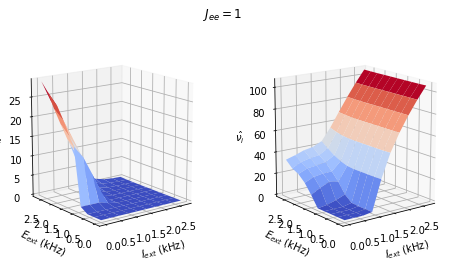

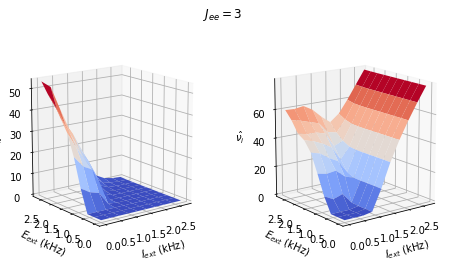

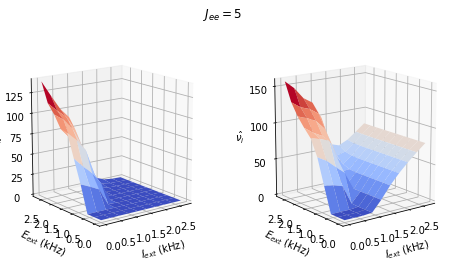

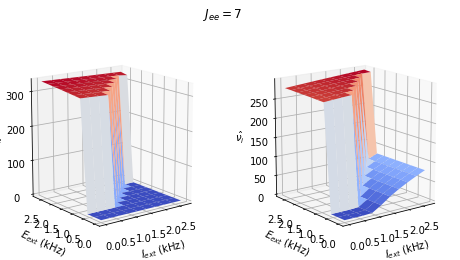

In [9]:
files = plotting.phase_plane_analysis(folders[0])

In [10]:
phase_plane_latex_string = ""
for file in files:
    phase_plane_latex_string += figure_template.render(figure=file,
                             caption="Phase Plane.",
                             width=0.9)

r$\nu_{exc, ext} = 1500.0$
r$\nu_{0, inh, ext} = 0.0$
r$\nu_{1, inh, ext} = 300.0$
r$\nu_{2, inh, ext} = 600.0$
r$\nu_{3, inh, ext} = 900.0$
r$\nu_{4, inh, ext} = 1200.0$
r$\nu_{5, inh, ext} = 1500.0$
r$\nu_{7, inh, ext} = 2100.0$


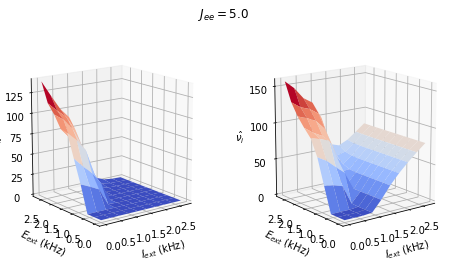

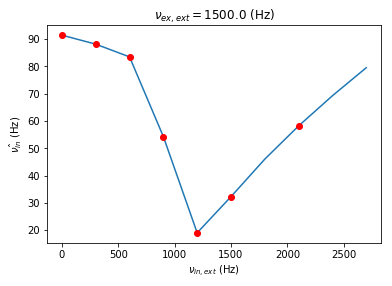

In [11]:
E, I = pickle.load( open(folders[0]+'/E_I.p', 'rb'))
with open(folders[0]+'/e_i_jee_5_0.p', 'rb') as file:
    e, i = pickle.load(file)
    fig, ax = plotting.phase_plane_plot(E, I, e, i, title=r'$J_{ee} = 5.0$')
    plotting.plot_intersections(ax, [0,1,2,3,4,5,7], 5, e, i, E, I, file='intersection.pdf')
    phase_plane_latex_string += figure_template.render(figure='intersection.pdf',
                             caption=r"Intersection for $J_{ee} = 5.0$",
                             width=0.9)

# Testing different display of visualisation

In [249]:
import pandas as pd

def visualisation_both(df_ex, df_in, title):
    """ 
    Visualizes two pandas dataframe for a spike detector. Position is needed.
    :param df_ex: Pandas dataframe for excitatory neurons
    :param df_in: Pandas dataframe for inhibitory neurons
    :param title: Title of the Plot
    :return: Return figure
    """
    fig = plt.figure()
    df_ex_time_cut = df_ex.groupby(pd.cut(df_ex['Time'], 12))
    df_in_time_cut = df_in.groupby(pd.cut(df_in['Time'], 12))
    gs0 = gridspec.GridSpec(2, 1)

    gs00 = gridspec.GridSpecFromSubplotSpec(4, 3, subplot_spec=gs0[0], wspace=0.0, hspace=0.0)
    gs01 = gridspec.GridSpecFromSubplotSpec(4, 3, subplot_spec=gs0[1], wspace=0.0, hspace=0.0)

    ax1 = []
    ax2 = []
    for i in range(4):
        for j in range(3):
            ax1.append(plt.subplot(gs00[i,j]))
            ax2.append(plt.subplot(gs01[i,j]))
#     fig.suptitle(title)
    plt.subplots_adjust(top=0.9, hspace=0.25, right=0.84)
    for df_now, ax in zip(df_ex_time_cut, ax1):
        x = [i[0] for i in df_now[1]['Position']]
        y = [i[1] for i in df_now[1]['Position']]
        img = ax.hist2d(x, y, bins=40, cmap=plt.cm.jet, normed=True, vmin=0., vmax=1.)
        ax.set_xticks([])
        ax.set_yticks([])
    for df_now, ax in zip(df_in_time_cut, ax2):
        x = [i[0] for i in df_now[1]['Position']]
        y = [i[1] for i in df_now[1]['Position']]
        img = ax.hist2d(x, y, bins=40, cmap=plt.cm.jet, normed=True, vmin=0., vmax=1.)
        ax.set_xticks([])
        ax.set_yticks([])
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(img[3], cax=cbar_ax, )
    fig.text(0.5, 0.08, 'X', ha='center')
    fig.text(0.48, 0.92, 'Excitatory Neurons', ha='center')
    fig.text(0.48, 0.5, 'Inhibitory Neurons', ha='center')
    fig.text(0.08, 0.5, 'Y', va='center', rotation='vertical')
    return fig

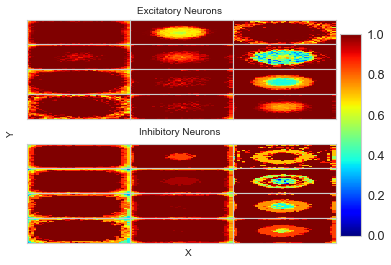

In [268]:
df_ex = pickle.load(open(folders[2]+'/df_ex.pickle', 'rb'))
df_in = pickle.load(open(folders[2]+'/df_in.pickle', 'rb'))
fig = plotting.visualisation_both(df_ex, df_in, title='Excitatory Population')

Current Folder: phase_plane_analysis/new_small/e0_15_i0_00
$\hat{\nu_i} = 0.00$


/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


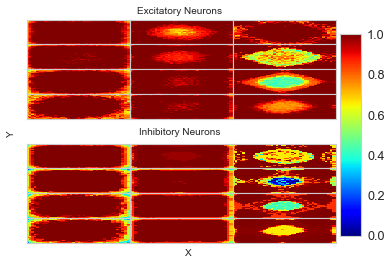

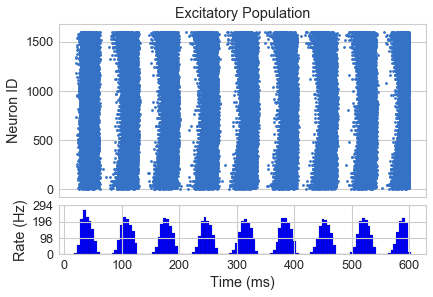

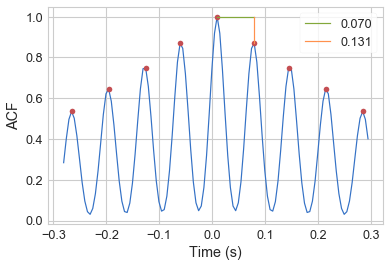

/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


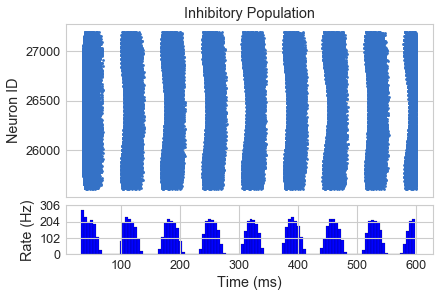

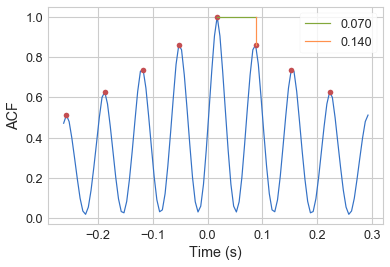

In [273]:
raster_autocorr_latex_string = ""
visu_latex_string = ""
for folder in folders[1:2]:
    if not 'stimulus' in folder:
        print("Current Folder: %s" % (folder,))
        para = plotting.getParams(folder, pickle_file='/parameter.pickle')
        print(r'$\hat{\nu_i} = %4.2f$' % (para['Background rate inhibitory'],))
        dynamics_and_raster_plot(folder, save=True, latex=True)

In [15]:
def files(path):  
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file
def files_start_with(start, path='.'):
    list_of_files = []
    for file in files(path):  
        if file.startswith(start):
            list_of_files.append(file)
    return sorted(list_of_files)
def parse_filename(file):
    return file.replace('.p','').split('_')

<Figure size 460.8x403.2 with 0 Axes>

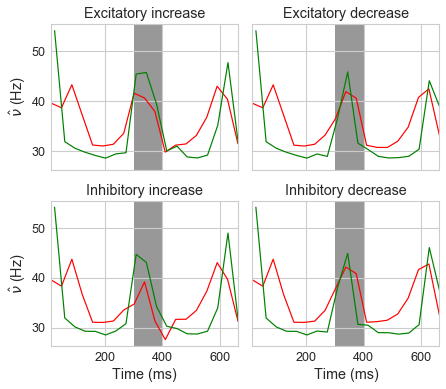

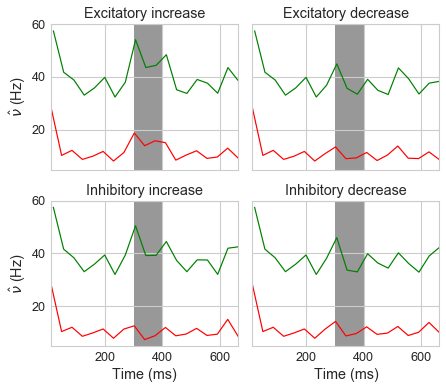

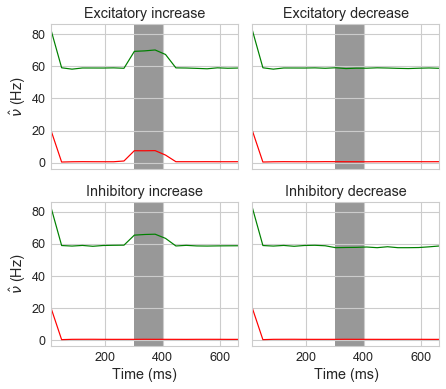

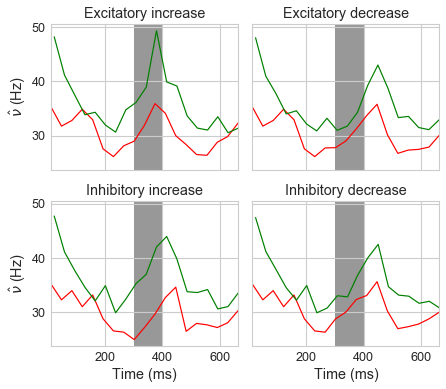

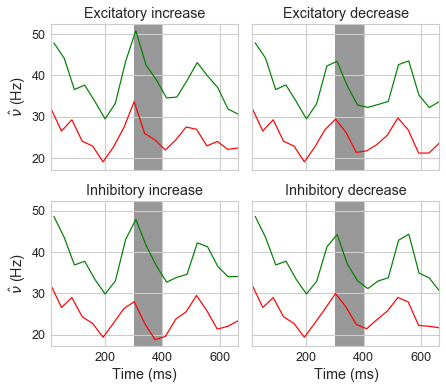

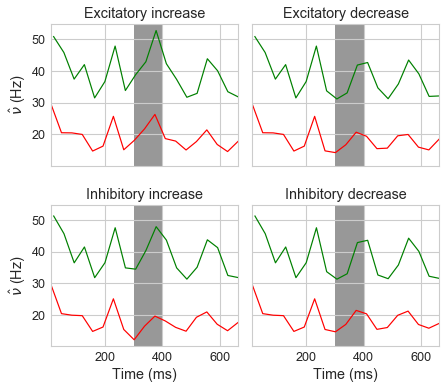

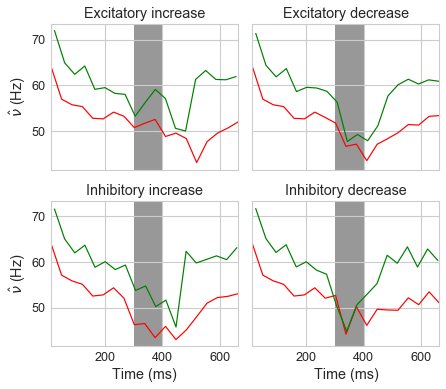

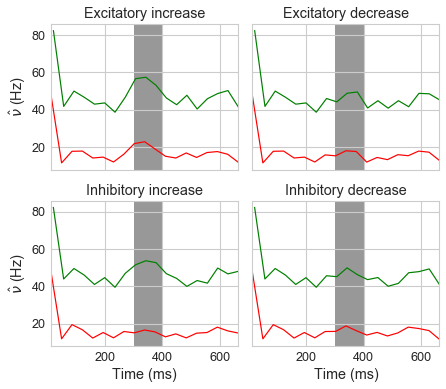

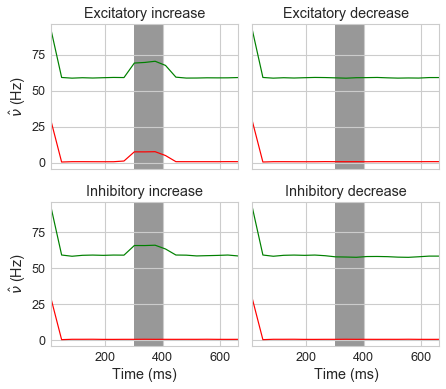

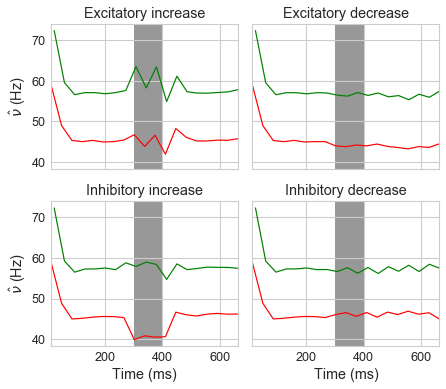

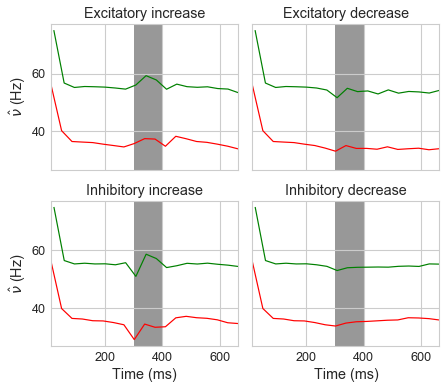

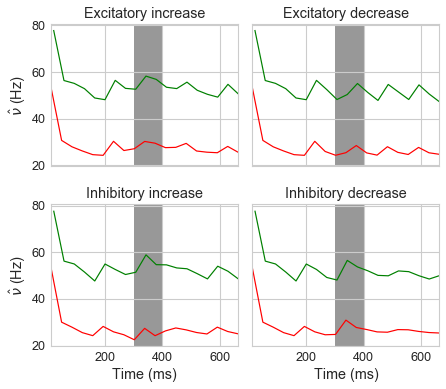

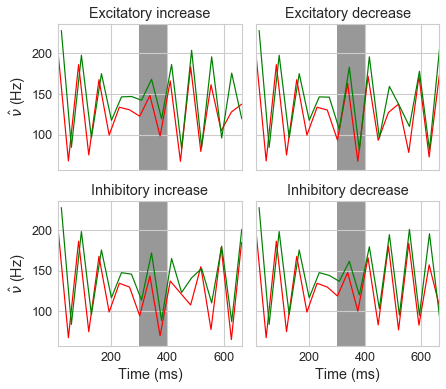

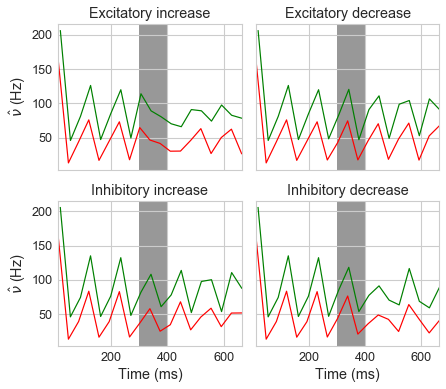

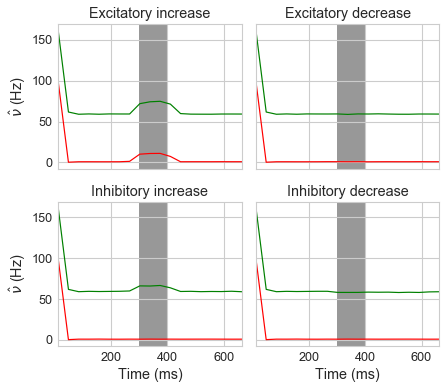

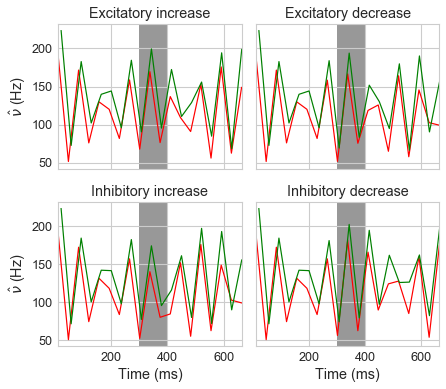

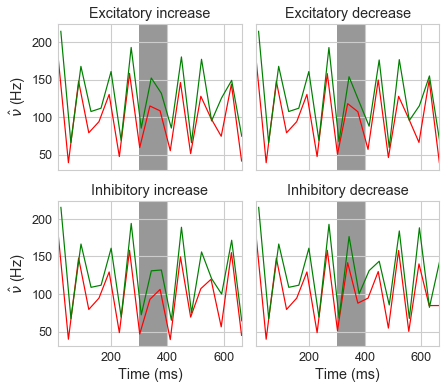

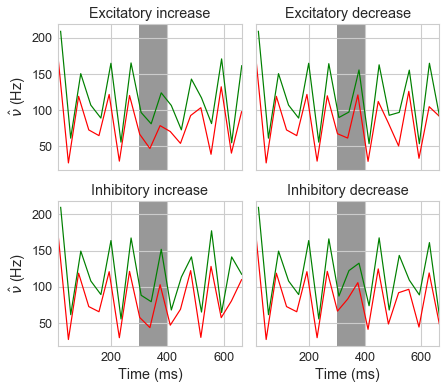

In [141]:
trace_latex_string = ""
path = folders[0]+'/stimulus/'
plt.clf()
fig_dict = {}
for file in files_start_with('exc_', path=path):
    if '-' in file:
        stats = parse_filename(file)
        tmp_file1 = path+file.replace('-','')
        tmp_file2 = path+file
        tmp_file3 = path+file.replace('exc', 'inh').replace('-','')
        tmp_file4 = path+file.replace('exc', 'inh')
        tmp_files = [tmp_file1, tmp_file2, tmp_file3, tmp_file4]
        fig = plotting.trace_plot_all_in_one(tmp_files, title='', 
                                 stim_start=300., 
                                 stim_end=400.)
        save_file_at = path+file.replace('exc_', '').replace('-300000', '')+"df"
        fig.savefig(save_file_at)
        trace_latex_string += figure_template.render(
            figure=save_file_at,
            caption=r"""
            Disturbance Test for $J_{ee} = %d$ and $\nu_{inh,ext} = %d \,\si{Hz}$.
            Excitatory population in green and inhibitory population in red. 
            Grey background is the time of increasing or decreasing stimulation 
            in the center of the network.
            """ % (int(stats[1]), int(stats[2])*100, ),
            width=0.9)
#         print(tmp_files)
#         fig_dict[file] = fig

In [274]:
with open('figures.tex', 'w') as f:
    f.write(latex_header)
    f.write(phase_plane_latex_string.replace('{ ','{').replace(' }','}'))
    f.write(r'\clearpage')
    f.write(visu_latex_string.replace('{ ','{').replace(' }','}'))
    f.write(r'\clearpage')
    f.write(raster_autocorr_latex_string.replace('{ ','{').replace(' }','}'))
    f.write(r'\clearpage')
    f.write(trace_latex_string.replace('{ ','{').replace(' }','}'))
    f.write(latex_footer)